# Lab 1: Causal Discovery based Markov Blanket Search

This notebook demonstrates:
1. Loading datasets and visualizing the DAG
2. Introducing Causal Discovery based Markov Blanket Search methods (CD-MB)
   - Evaluating causal discovery performance (NHD, precision, recall, F1)
   - Evaluating Markov Blanket feature selection performance
3. Comparing CD-MB methods

In [1]:
!git clone https://github.com/Shu-Wan/CSE472-blanket-challenge.git
%cd CSE472-blanket-challenge


Cloning into 'CSE472-blanket-challenge'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 204 (delta 88), reused 155 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 2.95 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/CSE472-blanket-challenge


In [2]:
import os
print(os.getcwd())


/content/CSE472-blanket-challenge


In [3]:
!pip install -e .


Obtaining file:///content/CSE472-blanket-challenge
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import sys
sys.path.append('/content/CSE472-blanket-challenge/src')  # ensures import works
import blanket
print("blanket imported successfully!")


blanket imported successfully!


In [ ]:
# %load_ext watermark
# %watermark -a "Shu Wan" -v

# %load_ext autoreload
# %autoreload 2

In [ ]:
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from huggingface_hub import snapshot_download
from datasets import load_dataset

from blanket.datasets import load_data
from blanket.feature_selection import (
    direct_lingam_selector,
    ges_selector,
    notears_selector,
    pc_selector,
)
from blanket.metrics import adjacency_confusion, jaccard_score, reduction_rate, shd
from blanket.plots import plot_adjmat, plot_graph

## 1. Load Dataset and Visualize DAG

In [ ]:
# Load dataset
datasets = load_dataset(path="CSE472-blanket-challenge/phase1-dataset", split="train")

datasets.features

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

linear_train.jsonl:   0%|          | 0.00/148M [00:00<?, ?B/s]

linear_test.jsonl:   0%|          | 0.00/35.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/180 [00:00<?, ? examples/s]

{'data_id': Value('string'),
 'graph_id': Value('string'),
 'X': List(List(Value('float64'))),
 'y': List(Value('float64')),
 'adjacency_matrix': List(List(Value('int64'))),
 'feature_mask': List(Value('int64')),
 'fs_method': Value('string'),
 'num_nodes': Value('int64'),
 'num_edges': Value('int64'),
 'density': Value('float64'),
 'graph_generation_method': Value('string')}

In [ ]:
example = datasets[70]
X = np.asarray(example["X"])
y = np.asarray(example["y"])
adj_mat = np.asarray(example["adjacency_matrix"])
num_nodes = example["num_nodes"]
density = example["density"]
mb = np.asarray(example["feature_mask"])

In [ ]:
X[0:3]

array([[-0.72 ,  0.506, -0.78 , -0.212,  0.029,  0.373, -0.413, -0.288,
        -0.6  ,  0.446,  0.252,  0.602,  0.106,  0.572],
       [-0.046,  0.828,  0.524,  0.083, -1.074,  0.968, -0.547,  0.587,
        -0.137,  0.836, -0.338, -0.195, -0.716,  1.146],
       [-0.656, -0.217, -0.369,  0.697, -0.22 ,  0.678,  0.645,  0.011,
        -0.646, -0.474, -0.292, -0.524, -0.691,  0.566]])

In [ ]:
y[0:3]

array([ 0.893, -0.313, -0.749])

In [ ]:
mb

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

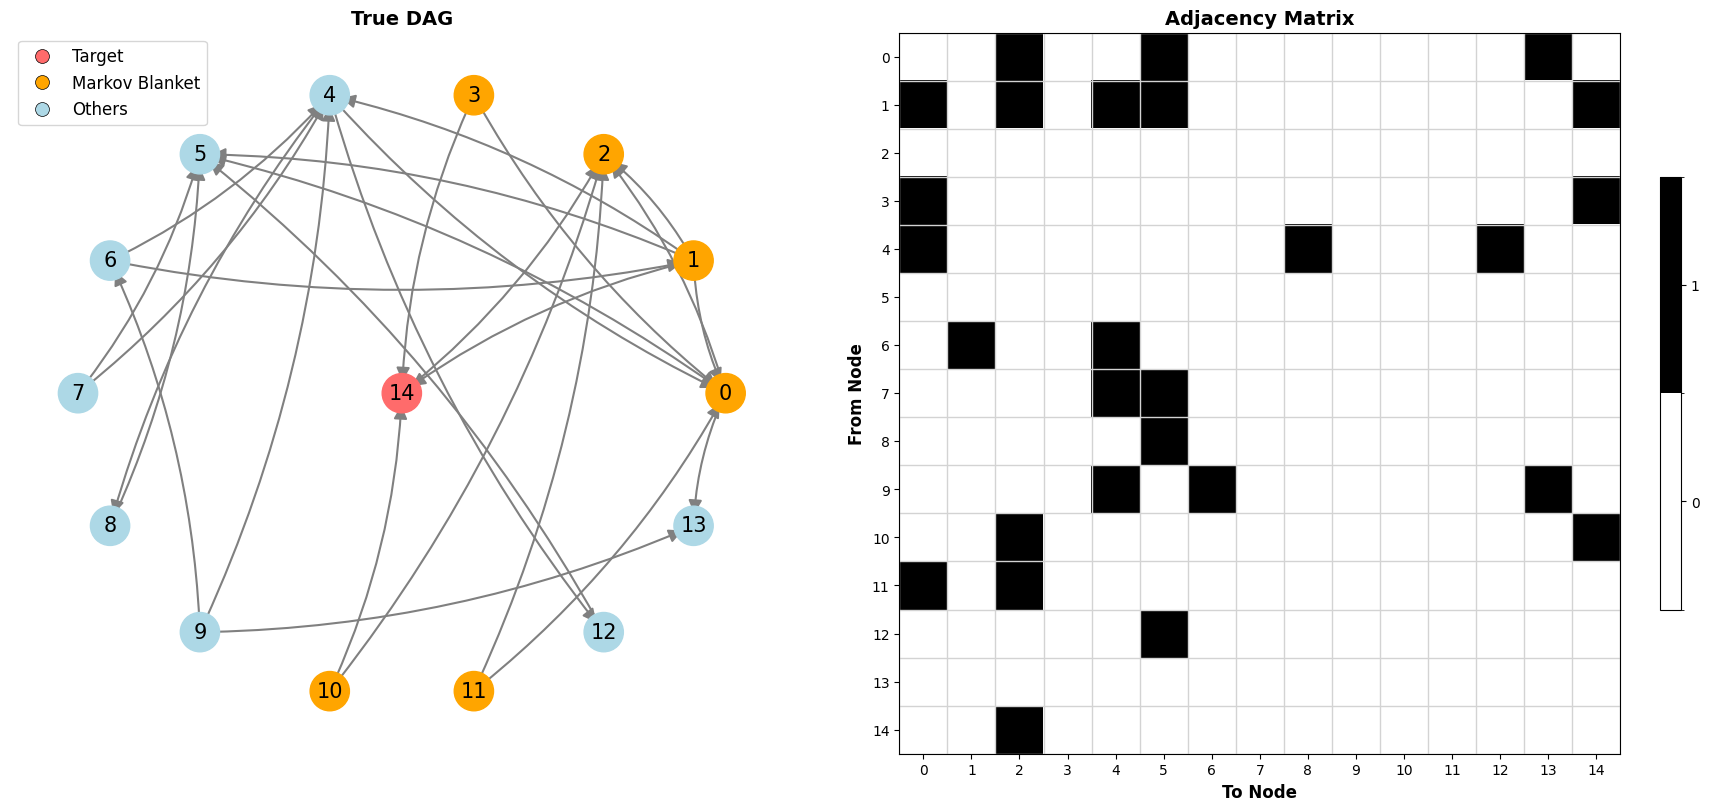

In [ ]:
# Visualize True DAG and Adjacency Matrix
fig, axes = plt.subplots(1, 2, figsize=(17, 8), constrained_layout=True)

plot_graph(adj_mat, figsize=(5, 5), ax=axes[0], title="True DAG")

plot_adjmat(
    adj_mat,
    title="Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1],
)

plt.show()

## 2. Causal Discovery based Markov Blanket Search (CD-MB)

The goal is to recover a target variable's Markov blanket (its parents, children, and spouses) by first learning a causal graph and then extracting the local neighborhood.

General Workflow
- Run a causal discovery algorithm on the data.
- Sanitize the learned graph (e.g., remove implausible edges, orient CPDAG edges if needed, ensure acyclicity).
- Extract the target's Markov blanket from the cleaned graph.

Pros
- Works with any causal discovery algorithm.
- One learned graph can be reused for multiple target variables.

Cons
- Algorithm assumptions matter (e.g., causal sufficiency, faithfulness, linearity, non‑Gaussianity).
- More often than not, CD method can not return a DAG but a CPDAG (equivalence class of DAGs).
- Many CD methods do not scale well on high‑dimensional data.
- Global structure learning can be wasteful when only a local (MB) neighborhood is needed. //(MB methods like IAMB can be more efficient)

In this tutorial we compare four families of causal discovery methods:
- PC — constraint‑based.
- GES — score‑based.
- DirectLiNGAM — functional/ICA‑based (non‑Gaussian noise).
- NOTEARS — gradient/continuous optimization‑based (linear SEM with acyclicity penalty).

We use the [`gCastle`](https://github.com/huawei-noah/trustworthyAI/blob/master/gcastle) package for the causal discovery algorithms; see its documentation for details.

In [ ]:
len(X), X

(1000,
 array([[-0.72 ,  0.506, -0.78 , ...,  0.602,  0.106,  0.572],
        [-0.046,  0.828,  0.524, ..., -0.195, -0.716,  1.146],
        [-0.656, -0.217, -0.369, ..., -0.524, -0.691,  0.566],
        ...,
        [-0.122, -0.638, -0.013, ..., -1.183,  0.706, -0.145],
        [ 0.625,  0.191,  1.037, ...,  0.479, -0.166, -0.658],
        [ 0.56 ,  0.044,  0.601, ..., -0.355, -0.255, -0.385]]))

In [ ]:
len(y)

1000

In [ ]:
pc_feature, pc_adjmat = pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable")
ges_feature, ges_adjmat = ges_selector(X, y, criterion="bic", method="scatter")
direct_lingam_feature, direct_lingam_adjmat = direct_lingam_selector(
    X, y, measure="pwling", thresh=0.3
)
notears_feature, notears_adjmat = notears_selector(X, y, lambda1=0.1, loss_type="l2")

Some CD algos returns a class of graph called CPDAG, CPDAG contains undirected edges when the direction cannot be determined from conditional independence tests alone. // (CPDAG = Completed Partially Directed Acyclic Graph.)

For MB, we allow bidirectional edges

Some causal discovery methods return a CPDAG*, an equivalence class that includes undirected edges when orientation cannot be determined from conditional independence tests alone. For Markov‑blanket extraction, a partially oriented graph is acceptable; we permit undirected (bidirectional) edges. //(So using a CPDAG for MB extraction is allowed.) The minimal Markov blanket is known as the Markov boundary.

\*: Proposition 11.1, Introduction to Causal Inference

In [ ]:
G = nx.from_numpy_array(pc_adjmat, create_using=nx.DiGraph)
nx.is_directed_acyclic_graph(G)

False

In [ ]:
# Compute graph metrics (SHD, precision, recall, F1) and MB metrics for each discovered graph

cdmb_results = {
    "PC": (pc_feature, pc_adjmat),
    "GES": (ges_feature, ges_adjmat),
    "DirectLiNGAM": (direct_lingam_feature, direct_lingam_adjmat),
    "NOTEARS": (notears_feature, notears_adjmat),
}

rows = []
for name, results in cdmb_results.items():
    feature = results[0]
    adj = results[1]
    shd_val = shd(adj_mat, adj)
    precision, recall, f1 = adjacency_confusion(adj_mat, adj)

    mb_jaccard = jaccard_score(mb, feature)
    mb_size = int(np.sum(feature))
    mb_reduction = reduction_rate(feature)

    rows.append(
        {
            "Method": name,
            "SHD": int(shd_val),
            "Precision": float(precision),
            "Recall": float(recall),
            "F1 Score": float(f1),
            "MB Jaccard": float(mb_jaccard),
            "MB Size": mb_size,
            "Reduction Rate": float(mb_reduction),
        }
    )

# Create and display comparison table
comparison_df = pd.DataFrame(rows)
comparison_df.sort_values(by="F1 Score", ascending=False, inplace=False).reset_index(drop=True)


,Method,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,PC,12,0.857143,0.666667,0.750000,0.333333,2,0.857143
1,GES,34,0.414634,0.629630,0.500000,0.833333,5,0.642857
2,NOTEARS,20,0.888889,0.296296,0.444444,0.333333,2,0.857143
3,DirectLiNGAM,36,0.320000,0.296296,0.307692,0.500000,3,0.785714


From the result above, NoTEARS performs best

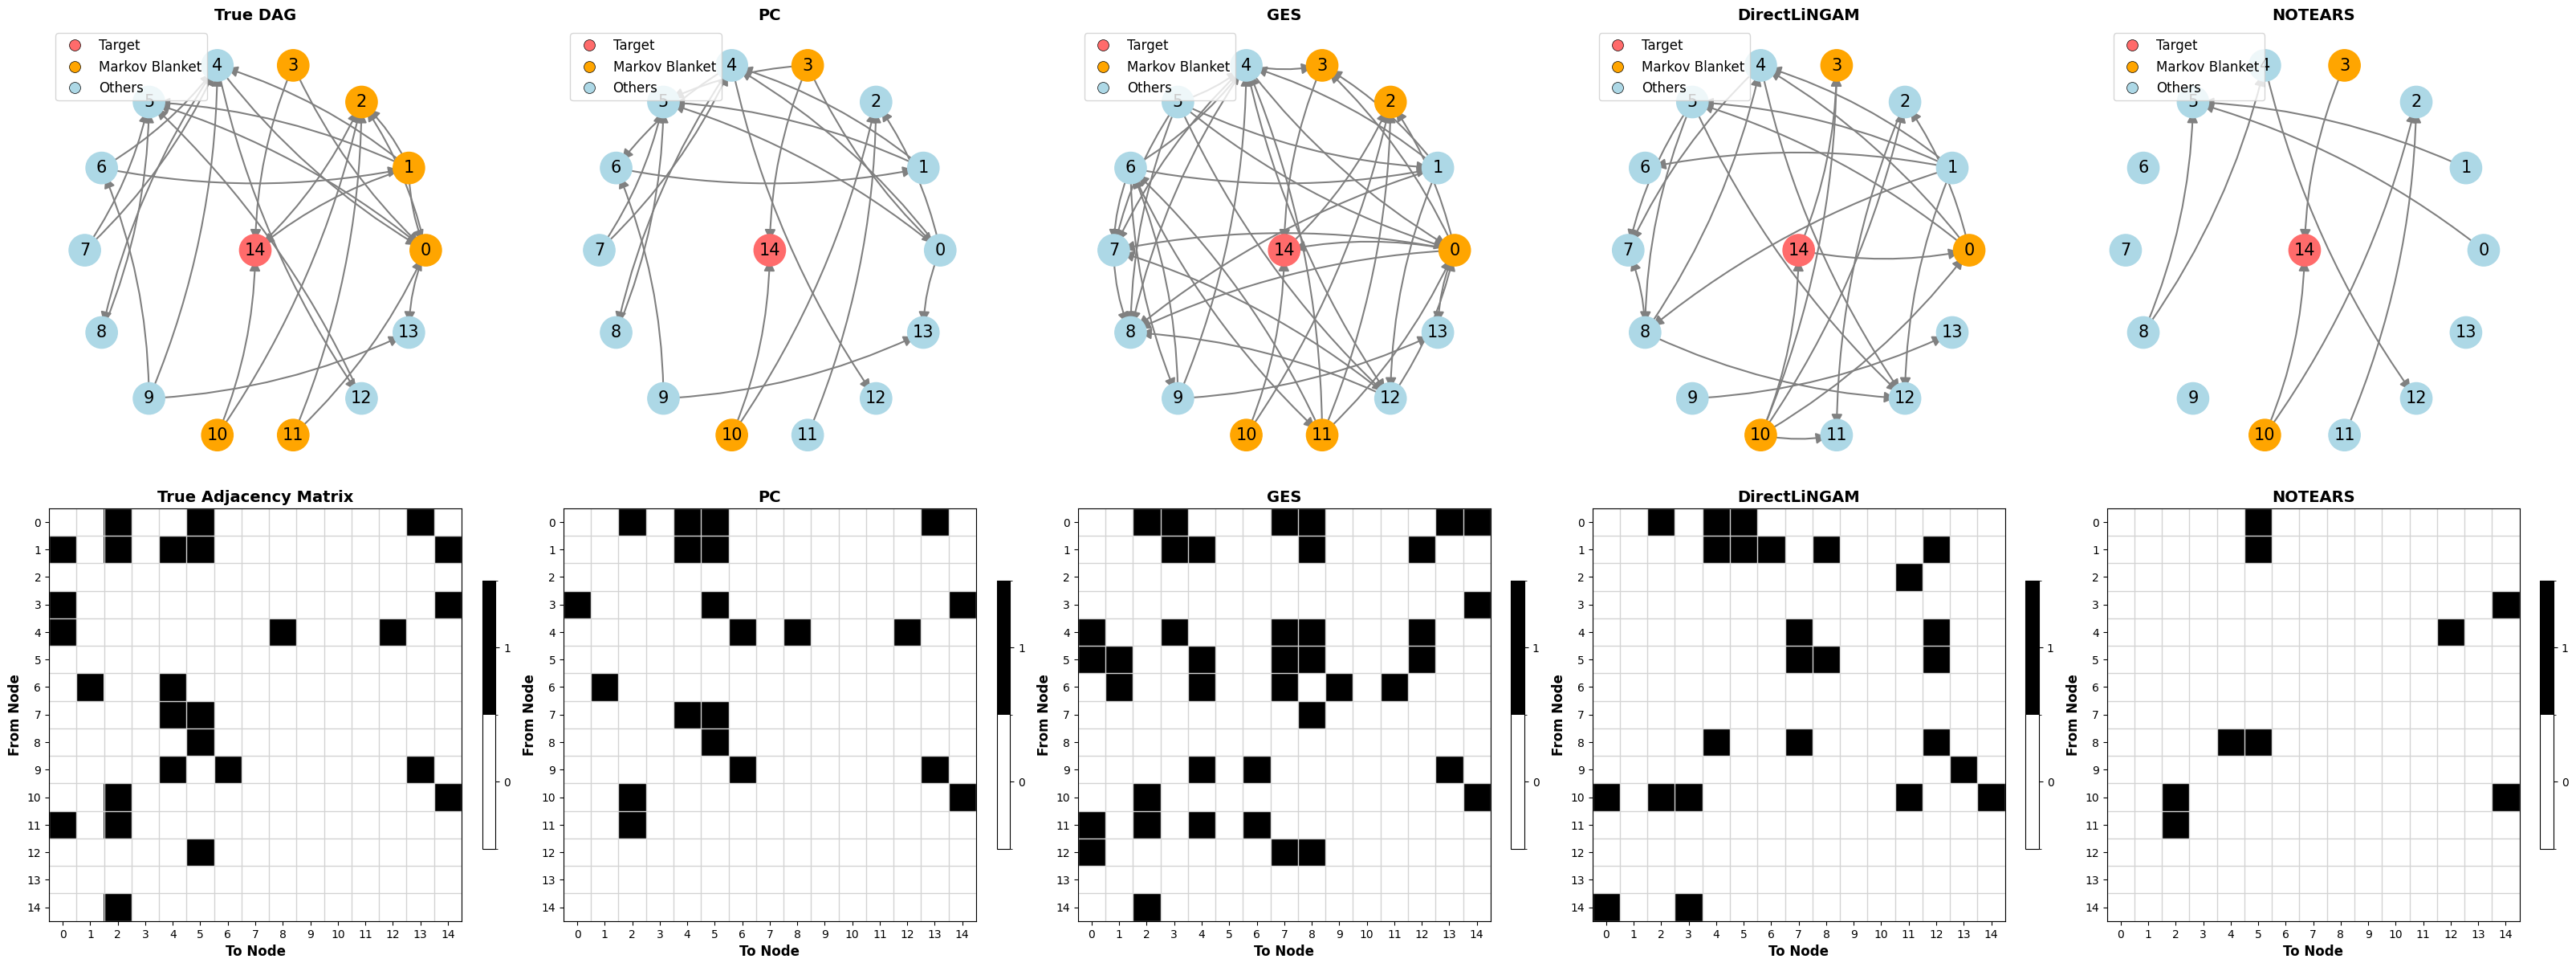

In [ ]:
# visualize the results

num_methods = len(cdmb_results)
fig, axes = plt.subplots(2, num_methods + 1, figsize=(num_methods * 8, 12), constrained_layout=True)

plot_graph(
    adj_mat,
    figsize=(5, 5),
    title="True DAG",
    ax=axes[0, 0],
)

plot_adjmat(
    adj_mat,
    title="True Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1, 0],
)

for i, (name, results) in enumerate(cdmb_results.items(), 1):
    adj = results[1]
    plot_graph(
        adj,
        figsize=(5, 5),
        title=f"{name}",
        ax=axes[0, i],
    )

    plot_adjmat(
        adj,
        title=f"{name}",
        figsize=(5, 5),
        ax=axes[1, i],
    )

plt.show()

## 4. Scale up

The above is just a small demo on one graph. Next, we run all CD-MB methods on 10 graphs, record time, and compare results.

In [ ]:
import time

# Set random seed for reproducibility
np.random.seed(42)

# Sample 10 graphs from the dataset
n_graphs = 10
sample_indices = np.random.choice(len(datasets), size=n_graphs, replace=False)

# Initialize results storage
all_results = []

# Run all CD algos on each sampled graph
for idx, sample_idx in enumerate(tqdm(sample_indices, total=n_graphs, desc="Processing graphs", unit="graph")):

    example = datasets[int(sample_idx)]

    # Reconstruct the DAG from adjacency matrix
    X = np.asarray(example["X"])
    y = np.asarray(example["y"])
    adj_mat = np.asarray(example["adjacency_matrix"])
    num_nodes = example["num_nodes"]
    num_edges = example["num_edges"]
    density = example["density"]
    oracle_mb = np.asarray(example["feature_mask"])

    # Run each algorithm and record time and results
    algorithms = {
        "PC": lambda: pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable"),
        "GES": lambda: ges_selector(X, y, criterion="bic", method="scatter"),
        "DirectLiNGAM": lambda: direct_lingam_selector(X, y, measure="pwling", thresh=0.3),
        "NOTEARS": lambda: notears_selector(X, y, lambda1=0.1, loss_type="l2"),
    }

    for algo_name, algo_func in algorithms.items():
        # Record time
        start_time = time.time()
        try:
            feature, discovered_adj = algo_func()
            end_time = time.time()
            runtime = end_time - start_time

            # Compute graph discovery metrics
            shd_val = shd(adj_mat, discovered_adj)
            precision, recall, f1 = adjacency_confusion(adj_mat, discovered_adj)

            # Compute MB metrics
            mb_jaccard = jaccard_score(oracle_mb, feature)
            mb_size = int(np.sum(feature))
            mb_reduction = reduction_rate(feature)
            oracle_mb_size = int(np.sum(oracle_mb))

            # Store results
            all_results.append({
                "Graph Index": sample_idx,
                "Graph ID": idx + 1,
                "Algorithm": algo_name,
                "Runtime (s)": runtime,
                "Num Nodes": num_nodes,
                "Num Edges": num_edges,
                "Density": density,
                "Oracle MB Size": oracle_mb_size,
                "SHD": int(shd_val),
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "MB Jaccard": mb_jaccard,
                "MB Size": mb_size,
                "Reduction Rate": mb_reduction,
            })
        except Exception as e:
            print(f"  Error in {algo_name}: {str(e)}")
            continue

# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df.head(10)

Processing graphs:   0%|          | 0/10 [00:00<?, ?graph/s]

,Graph Index,Graph ID,Algorithm,Runtime (s),Num Nodes,Num Edges,Density,Oracle MB Size,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,340,1,PC,1.053694,20,54,0.142105,12,45,0.628571,0.407407,0.494382,0.692308,10,0.473684
1,340,1,GES,24.407727,20,54,0.142105,12,57,0.476190,0.555556,0.512821,0.785714,13,0.315789
2,340,1,DirectLiNGAM,1.821331,20,54,0.142105,12,49,0.571429,0.370370,0.449438,0.666667,8,0.578947
3,340,1,NOTEARS,25.599246,20,54,0.142105,12,44,0.857143,0.222222,0.352941,0.083333,1,0.947368
4,290,2,PC,0.166262,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.777778,7,0.222222
5,290,2,GES,1.649965,10,24,0.266667,9,31,0.379310,0.458333,0.415094,1.000000,9,0.000000
6,290,2,DirectLiNGAM,0.413956,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.888889,8,0.111111
7,290,2,NOTEARS,2.460664,10,24,0.266667,9,17,1.000000,0.291667,0.451613,0.444444,4,0.555556
8,54,3,PC,0.852209,20,37,0.097368,9,33,0.566667,0.459459,0.507463,0.500000,6,0.684211
9,54,3,GES,21.010877,20,37,0.097368,9,29,0.576923,0.810811,0.674157,0.750000,12,0.368421


In [ ]:
results_df

,Graph Index,Graph ID,Algorithm,Runtime (s),Num Nodes,Num Edges,Density,Oracle MB Size,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,340,1,PC,1.053694,20,54,0.142105,12,45,0.628571,0.407407,0.494382,0.692308,10,0.473684
1,340,1,GES,24.407727,20,54,0.142105,12,57,0.476190,0.555556,0.512821,0.785714,13,0.315789
2,340,1,DirectLiNGAM,1.821331,20,54,0.142105,12,49,0.571429,0.370370,0.449438,0.666667,8,0.578947
3,340,1,NOTEARS,25.599246,20,54,0.142105,12,44,0.857143,0.222222,0.352941,0.083333,1,0.947368
4,290,2,PC,0.166262,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.777778,7,0.222222
5,290,2,GES,1.649965,10,24,0.266667,9,31,0.379310,0.458333,0.415094,1.000000,9,0.000000
6,290,2,DirectLiNGAM,0.413956,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.888889,8,0.111111
7,290,2,NOTEARS,2.460664,10,24,0.266667,9,17,1.000000,0.291667,0.451613,0.444444,4,0.555556
8,54,3,PC,0.852209,20,37,0.097368,9,33,0.566667,0.459459,0.507463,0.500000,6,0.684211
9,54,3,GES,21.010877,20,37,0.097368,9,29,0.576923,0.810811,0.674157,0.750000,12,0.368421


In [ ]:
# Summary by algorithm
summary_by_algo = results_df.groupby("Algorithm").agg({
    "Runtime (s)": ["mean", "std", "min", "max"],
    "SHD": ["mean", "std"],
    "Precision": ["mean", "std"],
    "Recall": ["mean", "std"],
    "F1 Score": ["mean", "std"],
    "MB Jaccard": ["mean", "std"],
    "Reduction Rate": ["mean", "std"],
}).round(4)

summary_by_algo

Runtime (s)                             SHD          Precision  \
                    mean      std     min      max  mean      std      mean   
Algorithm                                                                     
DirectLiNGAM      1.4535   0.7616  0.2544   2.7073  39.7  22.8427    0.5522   
GES              18.0661  18.6812  1.2553  64.2463  41.1  41.1837    0.5739   
NOTEARS          11.5159  11.0493  1.9774  29.7942  34.1  21.7891    0.8908   
PC                0.8645   0.6258  0.1663   2.1254  37.9  28.0295    0.5932   

                      Recall         F1 Score         MB Jaccard          \
                 std    mean     std     mean     std       mean     std   
Algorithm                                                                  
DirectLiNGAM  0.0889  0.3405  0.0773   0.4192  0.0820     0.5069  0.4228   
GES           0.1651  0.6477  0.1364   0.6054  0.1459     0.7303  0.2360   
NOTEARS       0.1400  0.2369  0.0660   0.3705  0.0921     0.1686  0.1927   
PC            0.1363  0.4091  0.1443   0.4808  0.1457     0.5196  0.2581   

             Reduction Rate          
                       mean     std  
Algorithm                            
DirectLiNGAM         0.6616  0.3271  
GES                  0.5458  0.2905  
NOTEARS              0.9057  0.1354  
PC                   0.6351  0.1917

## 4.1 Compare Algorithm Performance

In [ ]:
# Summary Table: Runtime Performance
print("\n" + "="*100)
print("SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

runtime_summary = results_df.groupby("Algorithm")["Runtime (s)"].agg(["count", "mean", "std", "min", "max"]).round(4)
runtime_summary.columns = ["Count", "Mean (s)", "Std (s)", "Min (s)", "Max (s)"]
runtime_summary


SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM



,Count,Mean (s),Std (s),Min (s),Max (s)
Algorithm,,,,,
DirectLiNGAM,10,1.4535,0.7616,0.2544,2.7073
GES,10,18.0661,18.6812,1.2553,64.2463
NOTEARS,10,11.5159,11.0493,1.9774,29.7942
PC,10,0.8645,0.6258,0.1663,2.1254


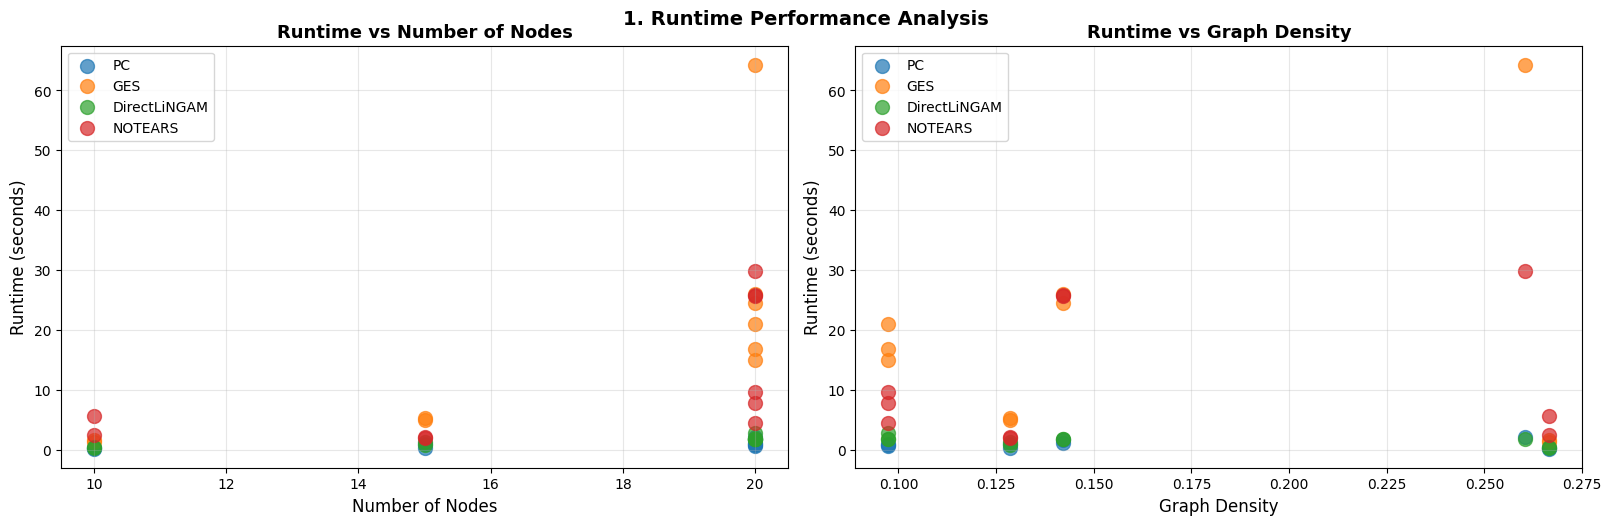

In [ ]:
# Define color palette for algorithms
algo_colors = {
    "PC": "#1f77b4",
    "GES": "#ff7f0e",
    "DirectLiNGAM": "#2ca02c",
    "NOTEARS": "#d62728"
}

# Create figure with subplots for Runtime vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: Runtime vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Runtime (seconds)", fontsize=12)
axes[0].set_title("Runtime vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Runtime vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Runtime (seconds)", fontsize=12)
axes[1].set_title("Runtime vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle("1. Runtime Performance Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.show()


In [ ]:
#how well each causal discovery algorithm recovered the graph structure

In [ ]:
# Summary Table: Graph Discovery Performance (F1 Score)
print("\n" + "="*100)
print("SUMMARY: GRAPH DISCOVERY PERFORMANCE (F1 SCORE) BY ALGORITHM")
print("="*100 + "\n")

f1_summary = results_df.groupby("Algorithm")[["SHD", "Precision", "Recall", "F1 Score"]].agg(["mean", "std"]).round(4)
f1_summary


SUMMARY: GRAPH DISCOVERY PERFORMANCE (F1 SCORE) BY ALGORITHM



SHD          Precision          Recall         F1 Score        
              mean      std      mean     std    mean     std     mean     std
Algorithm                                                                     
DirectLiNGAM  39.7  22.8427    0.5522  0.0889  0.3405  0.0773   0.4192  0.0820
GES           41.1  41.1837    0.5739  0.1651  0.6477  0.1364   0.6054  0.1459
NOTEARS       34.1  21.7891    0.8908  0.1400  0.2369  0.0660   0.3705  0.0921
PC            37.9  28.0295    0.5932  0.1363  0.4091  0.1443   0.4808  0.1457

Note that I did not optimize hyperparameters for each method; better performance may be possible with tuning.

F1 score std is fairly high compared to mean, indicating one hyperparameter setting may not fit all graphs well.

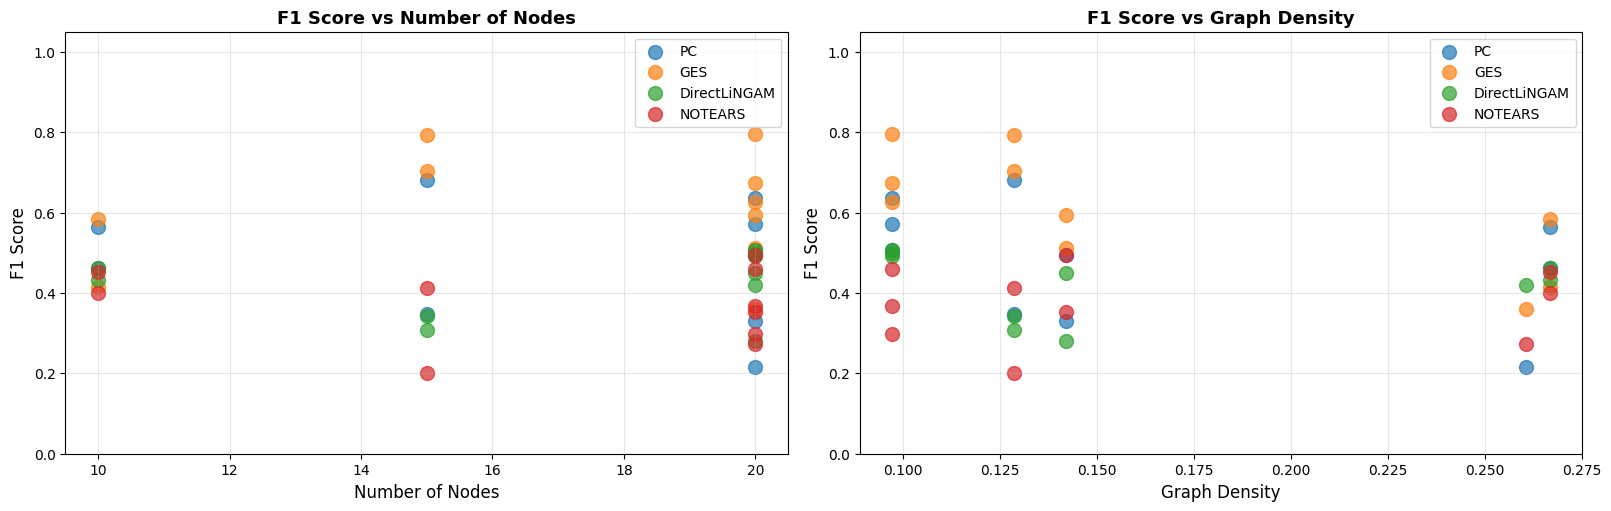

In [ ]:
# Create figure with subplots for F1 Score vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: F1 Score vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["F1 Score"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("F1 Score", fontsize=12)
axes[0].set_title("F1 Score vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: F1 Score vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["F1 Score"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("F1 Score", fontsize=12)
axes[1].set_title("F1 Score vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.show()


In [ ]:
# Summary Table: Markov Blanket Feature Selection Performance
print("\n" + "="*100)
print("SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

mb_summary = results_df.groupby("Algorithm")[["MB Jaccard", "MB Size", "Reduction Rate"]].agg(["mean", "std"]).round(4)
print(mb_summary)


SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM

             MB Jaccard         MB Size         Reduction Rate        
                   mean     std    mean     std           mean     std
Algorithm                                                             
DirectLiNGAM     0.5069  0.4228     5.1  5.1737         0.6616  0.3271
GES              0.7303  0.2360     6.9  4.4585         0.5458  0.2905
NOTEARS          0.1686  0.1927     1.2  1.3984         0.9057  0.1354
PC               0.5196  0.2581     5.5  2.6352         0.6351  0.1917


MB performance is aligned with graph discovery performance

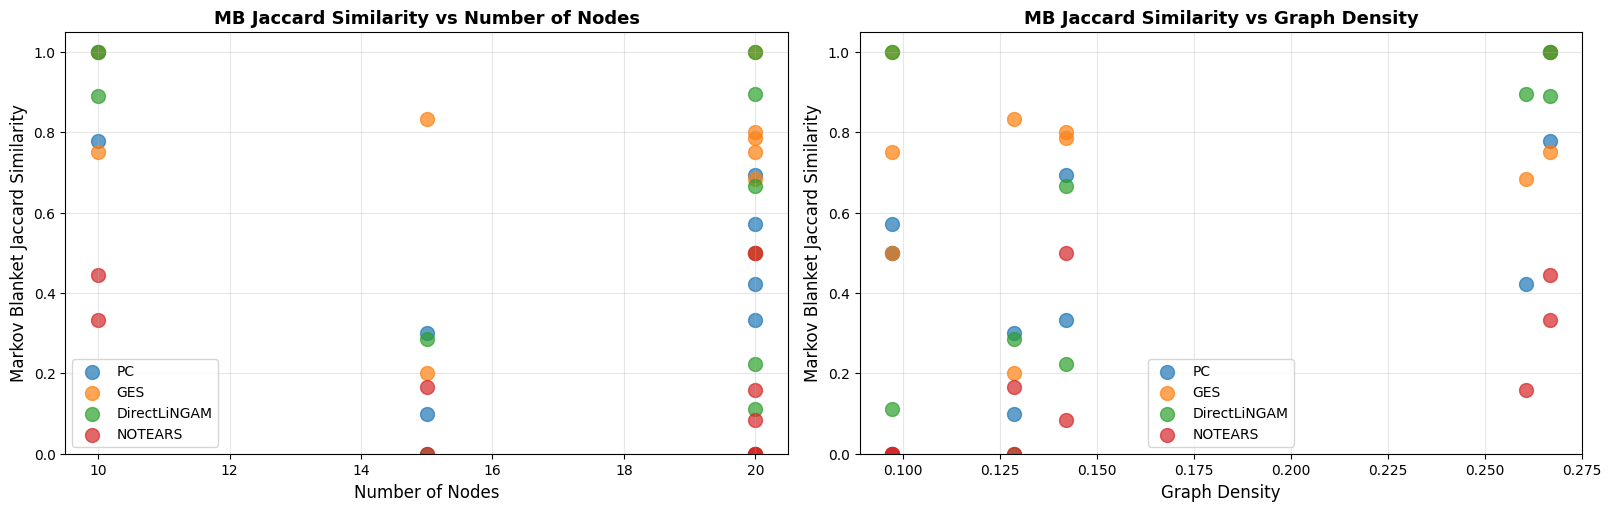

In [ ]:
# Create figure with subplots for Jaccard Similarity vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: MB Jaccard vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[0].set_title("MB Jaccard Similarity vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: MB Jaccard vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[1].set_title("MB Jaccard Similarity vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.show()


## 4.2 Markov Blanket Analysis: Relationship between MB Size, Density, and Graph Structure

By definition, a MB of $Y$ shield $Y$ from the rest of the features:

$$P(Y | MB(Y), Z) = P(Y | MB(Y))$$

,where $Z \in X\setminus \{Y, MB(Y)\}$.

From this definition, we can infer that the all features, i.e $X \setminus \{Y\}$, is a trivial MB of $Y$.

Therefore, if a MB is close to the size of all features, it is not very useful to do MB search.
In the following, for each graph, we iterate through all nodes and calculate their MBs to understand how MB size relates to graph density and structure.

In [ ]:
from blanket.graph import get_markov_blanket

# Compute MB for all nodes in each graph
mb_analysis_data = []

for graph_idx, sample_idx in enumerate(sample_indices):
    example = datasets[int(sample_idx)]
    adj_mat = np.asarray(example["adjacency_matrix"])
    num_nodes = example["num_nodes"]
    num_edges = example["num_edges"]
    density = example["density"]

    # Compute MB for each node
    for node_id in range(num_nodes):
        mb = get_markov_blanket(adj_mat, node_id)
        mb_size = sum(mb)
        mb_ratio = mb_size / (num_nodes - 1)

        mb_analysis_data.append({
            "Graph Index": sample_idx,
            "Graph ID": graph_idx + 1,
            "Node ID": node_id,
            "Num Nodes": num_nodes,
            "Num Edges": num_edges,
            "Density": density,
            "MB Size": mb_size,
            "MB Ratio": mb_ratio,
        })

mb_analysis_df = pd.DataFrame(mb_analysis_data)


In [ ]:
mb_analysis_df.groupby("Graph ID")[["MB Ratio", "Density", "Num Nodes"]].agg(["mean", "std"]).round(4)

MB Ratio         Density      Num Nodes     
             mean     std    mean  std      mean  std
Graph ID                                             
1          0.4737  0.2180  0.1421  0.0      20.0  0.0
2          0.8000  0.2015  0.2667  0.0      10.0  0.0
3          0.3895  0.2136  0.0974  0.0      20.0  0.0
4          0.3211  0.2020  0.0974  0.0      20.0  0.0
5          0.4762  0.2237  0.1286  0.0      15.0  0.0
6          0.3737  0.2213  0.1421  0.0      20.0  0.0
7          0.8222  0.1974  0.2667  0.0      10.0  0.0
8          0.4667  0.2158  0.1286  0.0      15.0  0.0
9          0.7526  0.1999  0.2605  0.0      20.0  0.0
10         0.3211  0.2020  0.0974  0.0      20.0  0.0

1. When density exceeds 0.2, the average MB ratio is over 0.7. Noted that it already includes trivial nodes such as the root node with a limited MB. In practice, target variables are typically meaningful and thus not trivial. Hence, the average MB ratio could even be larger.
2. Consequently, in many cases, identifying the MB is not particularly informative.
3. It may seem counterintuitive, but densities of 0.1–0.2 are not sparse. Truly sparse graphs usually have densities below 0.001, which generally requires a large number of nodes (>1000). We leave this for future work.

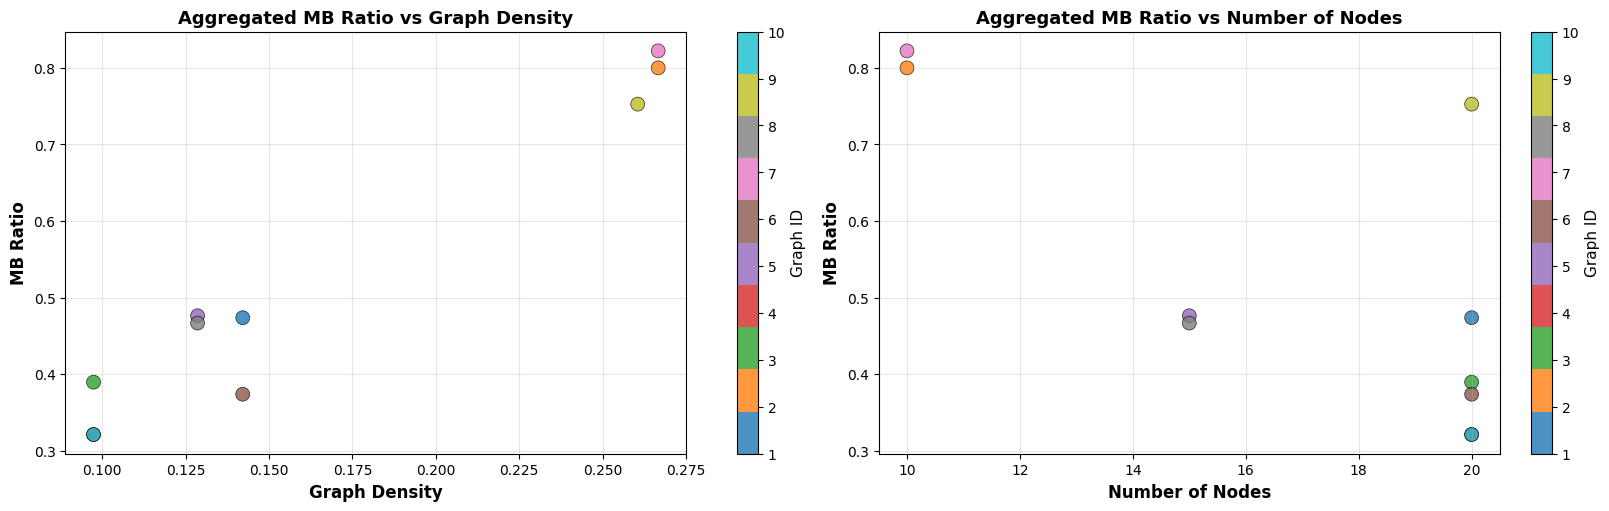

In [ ]:
# Aggregate MB Ratio by Graph ID
aggregated_mb_df = mb_analysis_df.groupby("Graph ID").agg({
    "MB Ratio": "mean",
    "Density": "mean",
    "Num Nodes": "mean"
}).reset_index()

# Visualization: Aggregated MB Ratio vs Graph Properties (colored by Graph ID)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: Aggregated MB Ratio vs Density with Graph ID coloring
scatter1 = axes[0].scatter(aggregated_mb_df["Density"], aggregated_mb_df["MB Ratio"],
                           c=aggregated_mb_df["Graph ID"], cmap="tab10",
                           s=100, alpha=0.8, edgecolors="black", linewidth=0.5)
axes[0].set_xlabel("Graph Density", fontsize=12, fontweight="bold")
axes[0].set_ylabel("MB Ratio", fontsize=12, fontweight="bold")
axes[0].set_title("Aggregated MB Ratio vs Graph Density", fontsize=13, fontweight="bold")
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label("Graph ID", fontsize=11)

# Plot 2: Aggregated MB Ratio vs Num Nodes with Graph ID coloring
scatter2 = axes[1].scatter(aggregated_mb_df["Num Nodes"], aggregated_mb_df["MB Ratio"],
                           c=aggregated_mb_df["Graph ID"], cmap="tab10",
                           s=100, alpha=0.8, edgecolors="black", linewidth=0.5)
axes[1].set_xlabel("Number of Nodes", fontsize=12, fontweight="bold")
axes[1].set_ylabel("MB Ratio", fontsize=12, fontweight="bold")
axes[1].set_title("Aggregated MB Ratio vs Number of Nodes", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label("Graph ID", fontsize=11)

plt.show()

## Bonus

1. [5 point] Implement a specialized causal feature selection method (IAMB)
- [bnlearn](https://github.com/cran/bnlearn) implements IAMB, fastIAMB. Using [rpy2](https://rpy2.github.io/) or write a R script to run it (if you're familiar with R).
- [py-tetrad](https://github.com/cmu-phil/py-tetrad) also provides IAMB implementations.
2. Is dedicated causal feature selection method (IAMB) working better than causal discovery methods?

(2. Answered at the end with all the other questions)

In [ ]:
import numpy as np
from scipy.stats import norm

def fisher_z_pvalue(i, j, cond_set, data):
    """
    Conditional independence test using Fisher-Z on partial correlation.
    data: (n_samples, n_vars) numpy array
    i, j: indices of variables to test
    cond_set: list of indices to condition on
    Returns: p-value for H0: X_i ⟂ X_j | X_cond_set
    """
    # variables involved in the test
    idxs = [i, j] + list(cond_set)
    sub_data = data[:, idxs]

    # covariance and precision
    cov = np.cov(sub_data, rowvar=False)
    prec = np.linalg.pinv(cov)   # pseudo-inverse for stability

    # partial correlation between first two vars given the rest
    # formula: rho_ij.Z = -P_ij / sqrt(P_ii * P_jj)
    p_ij = -prec[0, 1]
    p_ii = prec[0, 0]
    p_jj = prec[1, 1]
    rho = p_ij / np.sqrt(p_ii * p_jj + 1e-12)

    # clip numerical issues
    rho = np.clip(rho, -0.999999, 0.999999)

    n = data.shape[0]
    k = len(cond_set)
    # Fisher Z-transform
    z = 0.5 * np.log((1 + rho) / (1 - rho)) * np.sqrt(max(n - k - 3, 1))
    pval = 2 * (1 - norm.cdf(abs(z)))
    return pval


def iamb_mb(target_idx, feature_idxs, data, alpha=0.05):
    """
    Incremental Association Markov Blanket (IAMB) for a single target.

    target_idx: index of target variable in 'data'
    feature_idxs: list of candidate feature indices (excluding target)
    data: (n_samples, n_vars) numpy array (features + target)
    alpha: significance threshold for CI tests
    Returns: set of indices in the Markov blanket of target_idx
    """
    MB = set()

    changed = True
    while changed:
        changed = False
        best_var = None
        best_assoc = 0.0

        for X in feature_idxs:
            if X in MB:
                continue
            pval = fisher_z_pvalue(X, target_idx, MB, data)
            if pval < alpha:
                assoc = -np.log(pval + 1e-12)  # higher = stronger dependence
                if assoc > best_assoc:
                    best_assoc = assoc
                    best_var = X

        if best_var is not None:
            MB.add(best_var)
            changed = True

    changed = True
    while changed:
        changed = False
        for X in list(MB):
            cond_set = MB - {X}
            pval = fisher_z_pvalue(X, target_idx, cond_set, data)
            if pval >= alpha:
                MB.remove(X)
                changed = True

    return MB


def iamb_selector(X, y, alpha=0.05):
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1, 1)

    data = np.hstack([X, y])
    target_idx = data.shape[1] - 1
    feature_idxs = list(range(data.shape[1] - 1))

    mb_set = iamb_mb(target_idx, feature_idxs, data, alpha=alpha)

    p = X.shape[1]
    feature_mask = np.zeros(p, dtype=int)
    for j in mb_set:
        feature_mask[j] = 1

    adj_mat = np.zeros((p + 1, p + 1), dtype=int)
    for j in mb_set:
        adj_mat[j, p] = 1
        adj_mat[p, j] = 1

    return feature_mask, adj_mat

In [ ]:
import time

# Set random seed for reproducibility
np.random.seed(42)

# Sample 10 graphs from the dataset
n_graphs = 10
sample_indices = np.random.choice(len(datasets), size=n_graphs, replace=False)

# Initialize results storage
all_results = []

# Run all CD algos on each sampled graph
for idx, sample_idx in enumerate(tqdm(sample_indices, total=n_graphs, desc="Processing graphs", unit="graph")):

    example = datasets[int(sample_idx)]

    # Reconstruct the DAG from adjacency matrix
    X = np.asarray(example["X"])
    y = np.asarray(example["y"])
    adj_mat = np.asarray(example["adjacency_matrix"])
    num_nodes = example["num_nodes"]
    num_edges = example["num_edges"]
    density = example["density"]
    oracle_mb = np.asarray(example["feature_mask"])

    # Run each algorithm and record time and results
    # algorithms = {
    #     "PC": lambda: pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable"),
    #     "GES": lambda: ges_selector(X, y, criterion="bic", method="scatter"),
    #     "DirectLiNGAM": lambda: direct_lingam_selector(X, y, measure="pwling", thresh=0.3),
    #     "NOTEARS": lambda: notears_selector(X, y, lambda1=0.1, loss_type="l2"),
    # }
    algorithms = {
    "PC": lambda: pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable"),
    "GES": lambda: ges_selector(X, y, criterion="bic", method="scatter"),
    "DirectLiNGAM": lambda: direct_lingam_selector(X, y, measure="pwling", thresh=0.3),
    "NOTEARS": lambda: notears_selector(X, y, lambda1=0.1, loss_type="l2"),
    "IAMB": lambda: iamb_selector(X, y, alpha=0.05)   # Add this
    }


    for algo_name, algo_func in algorithms.items():
        # Record time
        start_time = time.time()
        try:
            feature, discovered_adj = algo_func()
            end_time = time.time()
            runtime = end_time - start_time

            # Compute graph discovery metrics
            shd_val = shd(adj_mat, discovered_adj)
            precision, recall, f1 = adjacency_confusion(adj_mat, discovered_adj)

            # Compute MB metrics
            mb_jaccard = jaccard_score(oracle_mb, feature)
            mb_size = int(np.sum(feature))
            mb_reduction = reduction_rate(feature)
            oracle_mb_size = int(np.sum(oracle_mb))

            # Store results
            all_results.append({
                "Graph Index": sample_idx,
                "Graph ID": idx + 1,
                "Algorithm": algo_name,
                "Runtime (s)": runtime,
                "Num Nodes": num_nodes,
                "Num Edges": num_edges,
                "Density": density,
                "Oracle MB Size": oracle_mb_size,
                "SHD": int(shd_val),
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "MB Jaccard": mb_jaccard,
                "MB Size": mb_size,
                "Reduction Rate": mb_reduction,
            })
        except Exception as e:
            print(f"  Error in {algo_name}: {str(e)}")
            continue

# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df.head(10)

Processing graphs:   0%|          | 0/10 [00:00<?, ?graph/s]

,Graph Index,Graph ID,Algorithm,Runtime (s),Num Nodes,Num Edges,Density,Oracle MB Size,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,340,1,PC,1.052308,20,54,0.142105,12,45,0.628571,0.407407,0.494382,0.692308,10,0.473684
1,340,1,GES,24.538037,20,54,0.142105,12,57,0.476190,0.555556,0.512821,0.785714,13,0.315789
2,340,1,DirectLiNGAM,1.827823,20,54,0.142105,12,49,0.571429,0.370370,0.449438,0.666667,8,0.578947
3,340,1,NOTEARS,25.406566,20,54,0.142105,12,44,0.857143,0.222222,0.352941,0.083333,1,0.947368
4,340,1,IAMB,0.074522,20,54,0.142105,12,64,0.222222,0.074074,0.111111,0.750000,9,0.526316
5,290,2,PC,0.145655,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.777778,7,0.222222
6,290,2,GES,1.584466,10,24,0.266667,9,31,0.379310,0.458333,0.415094,1.000000,9,0.000000
7,290,2,DirectLiNGAM,0.238340,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.888889,8,0.111111
8,290,2,NOTEARS,1.221246,10,24,0.266667,9,17,1.000000,0.291667,0.451613,0.444444,4,0.555556
9,290,2,IAMB,0.024722,10,24,0.266667,9,28,0.375000,0.250000,0.300000,0.888889,8,0.111111


In [ ]:
results_df

,Graph Index,Graph ID,Algorithm,Runtime (s),Num Nodes,Num Edges,Density,Oracle MB Size,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,340,1,PC,1.052308,20,54,0.142105,12,45,0.628571,0.407407,0.494382,0.692308,10,0.473684
1,340,1,GES,24.538037,20,54,0.142105,12,57,0.476190,0.555556,0.512821,0.785714,13,0.315789
2,340,1,DirectLiNGAM,1.827823,20,54,0.142105,12,49,0.571429,0.370370,0.449438,0.666667,8,0.578947
3,340,1,NOTEARS,25.406566,20,54,0.142105,12,44,0.857143,0.222222,0.352941,0.083333,1,0.947368
4,340,1,IAMB,0.074522,20,54,0.142105,12,64,0.222222,0.074074,0.111111,0.750000,9,0.526316
5,290,2,PC,0.145655,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.777778,7,0.222222
6,290,2,GES,1.584466,10,24,0.266667,9,31,0.379310,0.458333,0.415094,1.000000,9,0.000000
7,290,2,DirectLiNGAM,0.238340,10,24,0.266667,9,21,0.600000,0.375000,0.461538,0.888889,8,0.111111
8,290,2,NOTEARS,1.221246,10,24,0.266667,9,17,1.000000,0.291667,0.451613,0.444444,4,0.555556
9,290,2,IAMB,0.024722,10,24,0.266667,9,28,0.375000,0.250000,0.300000,0.888889,8,0.111111


In [ ]:
results_df["Algorithm"].unique()

array(['PC', 'GES', 'DirectLiNGAM', 'NOTEARS', 'IAMB'], dtype=object)

In [ ]:
# Summary by algorithm
summary_by_algo = results_df.groupby("Algorithm").agg({
    "Runtime (s)": ["mean", "std", "min", "max"],
    "SHD": ["mean", "std"],
    "Precision": ["mean", "std"],
    "Recall": ["mean", "std"],
    "F1 Score": ["mean", "std"],
    "MB Jaccard": ["mean", "std"],
    "Reduction Rate": ["mean", "std"],
}).round(4)

summary_by_algo

Runtime (s)                             SHD          Precision  \
                    mean      std     min      max  mean      std      mean   
Algorithm                                                                     
DirectLiNGAM      1.3733   0.7727  0.2383   2.5443  39.7  22.8427    0.5522   
GES              18.1208  18.0111  1.5845  62.2100  41.1  41.1837    0.5739   
IAMB              0.0525   0.0440  0.0151   0.1612  45.2  22.7635    0.3533   
NOTEARS          11.1521  11.5729  1.2212  31.2311  34.1  21.7891    0.8908   
PC                0.8445   0.5267  0.1457   1.6860  37.9  28.0295    0.5932   

                      Recall         F1 Score         MB Jaccard          \
                 std    mean     std     mean     std       mean     std   
Algorithm                                                                  
DirectLiNGAM  0.0889  0.3405  0.0773   0.4192  0.0820     0.5069  0.4228   
GES           0.1651  0.6477  0.1364   0.6054  0.1459     0.7303  0.2360   
IAMB          0.1159  0.1002  0.0633   0.1491  0.0738     0.7895  0.2313   
NOTEARS       0.1400  0.2369  0.0660   0.3705  0.0921     0.1686  0.1927   
PC            0.1363  0.4091  0.1443   0.4808  0.1457     0.5196  0.2581   

             Reduction Rate          
                       mean     std  
Algorithm                            
DirectLiNGAM         0.6616  0.3271  
GES                  0.5458  0.2905  
IAMB                 0.6139  0.2625  
NOTEARS              0.9057  0.1354  
PC                   0.6351  0.1917

In [ ]:
# Summary Table: Runtime Performance
print("\n" + "="*100)
print("SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

runtime_summary = results_df.groupby("Algorithm")["Runtime (s)"].agg(["count", "mean", "std", "min", "max"]).round(4)
runtime_summary.columns = ["Count", "Mean (s)", "Std (s)", "Min (s)", "Max (s)"]
runtime_summary


SUMMARY: RUNTIME PERFORMANCE BY ALGORITHM



,Count,Mean (s),Std (s),Min (s),Max (s)
Algorithm,,,,,
DirectLiNGAM,10,1.3733,0.7727,0.2383,2.5443
GES,10,18.1208,18.0111,1.5845,62.2100
IAMB,10,0.0525,0.0440,0.0151,0.1612
NOTEARS,10,11.1521,11.5729,1.2212,31.2311
PC,10,0.8445,0.5267,0.1457,1.6860


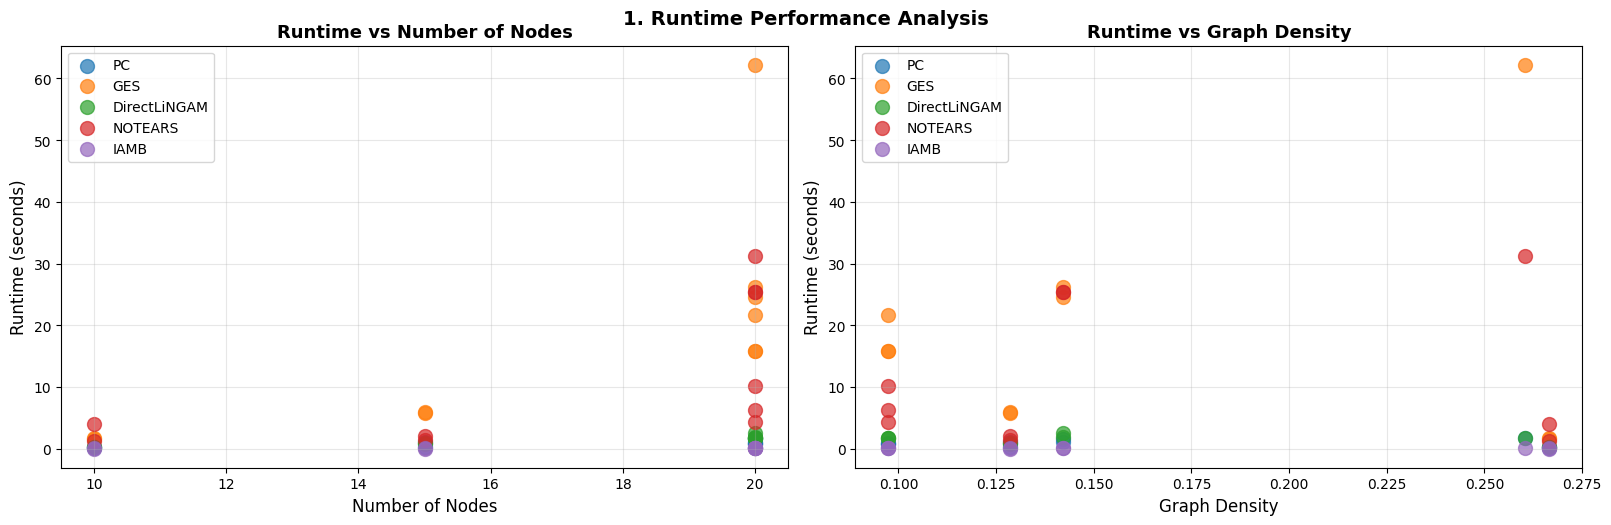

In [ ]:
# Define color palette for algorithms
algo_colors = {
    "PC": "#1f77b4",
    "GES": "#ff7f0e",
    "DirectLiNGAM": "#2ca02c",
    "NOTEARS": "#d62728",
    "IAMB": "#9467bd"   # New
}

# Create figure with subplots for Runtime vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: Runtime vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Runtime (seconds)", fontsize=12)
axes[0].set_title("Runtime vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Runtime vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["Runtime (s)"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Runtime (seconds)", fontsize=12)
axes[1].set_title("Runtime vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle("1. Runtime Performance Analysis", fontsize=14, fontweight="bold", y=1.02)
plt.show()


In [ ]:
# Summary Table: Markov Blanket Feature Selection Performance
print("\n" + "="*100)
print("SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM")
print("="*100 + "\n")

mb_summary = results_df.groupby("Algorithm")[["MB Jaccard", "MB Size", "Reduction Rate"]].agg(["mean", "std"]).round(4)
print(mb_summary)


SUMMARY: MARKOV BLANKET FEATURE SELECTION PERFORMANCE BY ALGORITHM

             MB Jaccard         MB Size         Reduction Rate        
                   mean     std    mean     std           mean     std
Algorithm                                                             
DirectLiNGAM     0.5069  0.4228     5.1  5.1737         0.6616  0.3271
GES              0.7303  0.2360     6.9  4.4585         0.5458  0.2905
IAMB             0.7895  0.2313     5.9  4.0125         0.6139  0.2625
NOTEARS          0.1686  0.1927     1.2  1.3984         0.9057  0.1354
PC               0.5196  0.2581     5.5  2.6352         0.6351  0.1917


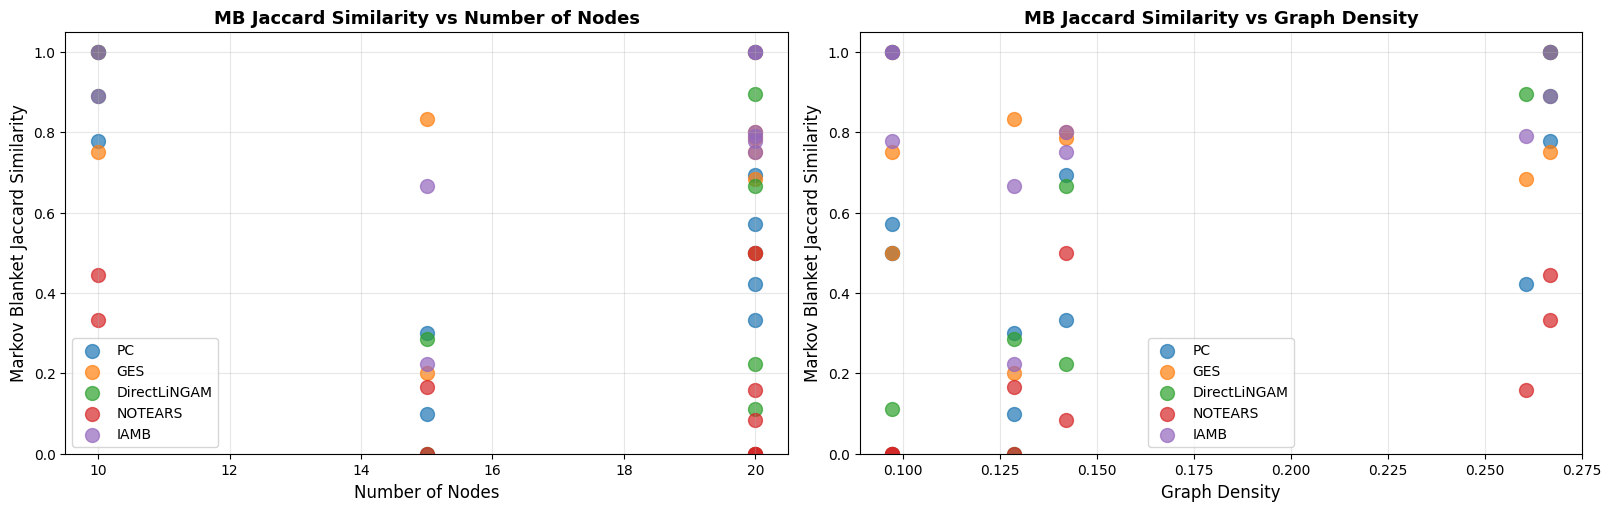

In [ ]:
# Create figure with subplots for Jaccard Similarity vs Graph Properties
fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

# Plot 1: MB Jaccard vs Num Nodes
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[0].scatter(algo_data["Num Nodes"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[0].set_xlabel("Number of Nodes", fontsize=12)
axes[0].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[0].set_title("MB Jaccard Similarity vs Number of Nodes", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: MB Jaccard vs Density
for algo in results_df["Algorithm"].unique():
    algo_data = results_df[results_df["Algorithm"] == algo]
    axes[1].scatter(algo_data["Density"], algo_data["MB Jaccard"],
                   label=algo, s=100, alpha=0.7, color=algo_colors[algo])

axes[1].set_xlabel("Graph Density", fontsize=12)
axes[1].set_ylabel("Markov Blanket Jaccard Similarity", fontsize=12)
axes[1].set_title("MB Jaccard Similarity vs Graph Density", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.show()


##Questions
1. Can PC recover the DAG well? (performance across degree, density, size of mb, training data size etc)

Based on the results, PC can recover the DAG reasonably but not exceptionally well. Its performance clearly depends on the graph's structural complexity (degree, density, size of mb) and training data size. The PC algorithm achieves a moderate average F1 score of 0.48 with a relatively high precision (0.593) but low recall (0.41). This tells us that it is better at confirming true edges than detecting all of them, that it, it tends to miss causal links rather than falsely include them.
Although it is comparatively efficient with a low runtime (0.86 s) and scales well computationally, its high SHD (37.9) means there are a substantial number of wrongly oriented or missing edges. This happens especially as the graph becomes denser or the number of nodes increases and can also been seen in the graphs. PC performs better on smaller and sparser graphs with simpler Markov blankets but struggles as graph density and node degree increase (probably due to more complex conditional independence tests).
While the training data size does improve its accuracy, PC is still sensitive to weak dependencies and higher-order conditioning which deteriorates its stability. Its MB Jaccard similarity (0.5196) and reduction rate (0.635) show that it filters features fairly well but is not optimized for Markov Blanket recovery, unlike dedicated MB methods such as IAMB.

2. Is causal discovery working well on the dataset? If not, what's your hypothesis? (use 3 as a hypothesis)

Overall, causal discovery methods do not recover the underlying DAG very well in this dataset. The F1 Scores are average (PC = 0.48, GES = 0.61, DirectLiNGAM = 0.42, NOTEARS = 0.37) and the SHD values are relatively high (PC = 37.9, GES = 41.1, NOTEARS = 34.1, DirectLiNGAM = 39.7), indicating many incorrect or missing edges. The performance fluctuates significantly across graphs, especially as density increases. Denser graphs tend to result in lower accuracy due to the higher number of conditional independence relationships to test. In terms of runtime, PC is the fastest (0.86 s on average), followed by DirectLiNGAM (1.45 s), while GES and NOTEARS are significantly slower (18.07 s and 11.52 s respectively). Despite the faster execution, PC does not lead to better graph accuracy.
Additionally, Markov Blanket recovery performance is moderate for PC (MB Jaccard = 0.52) and DirectLiNGAM (0.51), while GES performs slightly better (0.73) and NOTEARS performs poorly (0.17). This suggests that causal discovery methods also struggle to correctly capture the Markov Blanket of the target variable.
One likely hypothesis (referencing observation 3) for this poor performance is related to graph density. Many graphs in the dataset have densities between 0.1 and 0.26, which are not truly sparse. We observed that higher density leads to very large MB ratios (greater than 0.8). Such large MBs imply strong interconnectivity among variables where most features are directly or indirectly connected. In these cases, causal discovery algorithms struggle to identify conditional independencies accurately, resulting in ambiguous edge orientations and unstable graph recovery. GES and NOTEARS also take significantly longer in denser graphs due to more combinations to evaluate.

3. What's the relationship of size of Markov Blanket and density of the graph? (answer 2)

There is a clear positive relationship between the graph density and the size of the Markov Blanket. As the graph density increases, the Markov Blanket ratio also increases substantially. From the results it can be seen that graphs with denesities above 0.2 consistently show MB ratios greater than 0.7. The means that more nodes are part of each other's markov blankets. On the other hand, graphs with densities around 0.09 to 0.14 have significantly smaller MB ratios. This trend can also be seen in the scatter plots as dense graphs cluster toward the upper region of the MB ratio axis. Even though some graphs include trivial nodes, the average MB ratio is still high. This suggests that for meaningful target variables, the markov blanket would likely be even higher. This basically indicates high interconnectivity, where many variables directly or indirectly inflence each other. This result is a bit counterintuitive because densities of 0.1-0.2 may appear sparse, but in causal infernce terms they are not sparse enough. here true sparsity often means densities below 0.001 in high-dimensional settings. Thus when the markov blanket is large relative to the total number of features, mb identification becomes less informative as it no longer effectively isolates the minimal predictive set.


4. Is dedicated causal feature selection method (IAMB) working better than causal discovery methods?

Yes, the dedicated causal feature selection method IAMB works better than the general causal discovery methods (PC, GES, DirectLiNGAM, NOTEARS) for Markov Blanket recovery. It achieves the highest Markov Blanket Jaccard similarity of 0.7895 which indicates more accurate feature selection. Along with that, it is also the fastest among all the methods with an average runtime of 0.0525 seconds.

Unlike causal discovery algorithms that aim to reconstruct the full causal graph, IAMB is directly designed to identify the minimal set of variables relevant to the target. I think this contributes to it's better performance. Although causal discovery methods like GES also perform reasonably well, IAMB’s specialization for feature selection makes it more efficient and effective in this task.